In [1]:
import gc
from datetime import datetime, timedelta,date
import warnings
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection,johnson_lindenstrauss_min_dim
from sklearn.decomposition import PCA, FastICA,NMF,LatentDirichletAllocation,IncrementalPCA,MiniBatchSparsePCA
from sklearn.decomposition import TruncatedSVD,FactorAnalysis,KernelPCA

import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, log_loss, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, KFold

from scipy.stats import ks_2samp
import tqdm

#settings
warnings.filterwarnings('ignore')
np.random.seed(2018)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',130)

In [2]:
def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

In [3]:
def create_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [4]:
historical_trans_df = pd.read_csv('input/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('input/new_merchant_transactions.csv')
merchant_df = pd.read_csv('input/merchants.csv')
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

In [5]:
def get_hist_default_prorcessing(df):
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2}) 
    df['month_diff'] = ((datetime(2012,4,1) - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['reference_date'] = (df['year']+(df['month'] - df['month_lag'])//12)*100 + (((df['month'] - df['month_lag'])%12) + 1)*1
    return df

In [6]:
historical_trans_df = get_hist_default_prorcessing(historical_trans_df)
new_merchant_trans_df = get_hist_default_prorcessing(new_merchant_trans_df)

In [7]:
historical_trans_df = historical_trans_df.sort_values('purchase_date')
new_merchant_trans_df = new_merchant_trans_df.sort_values('purchase_date')

In [8]:
historical_trans_df.loc[historical_trans_df['installments']==999,'installments_999'] = 1
new_merchant_trans_df.loc[new_merchant_trans_df['installments']==999,'installments_999'] = 1

historical_trans_df.loc[historical_trans_df['installments']==999,'installments'] = -1
new_merchant_trans_df.loc[new_merchant_trans_df['installments']==999,'installments_999'] = -1

### Feature Engineering

In [9]:
all_df = pd.concat([train_df,test_df])

In [10]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'purchase_amount',['count','mean'])
group_df['card_id_month_lag_purchase_amount_count'] = group_df['card_id_month_lag_purchase_amount_count']/(1-group_df['month_lag'])
group_df['card_id_month_lag_purchase_amount_mean'] = group_df['card_id_month_lag_purchase_amount_mean']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_count',['sum','mean','std'])
mean_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_mean',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')
all_df = all_df.merge(mean_df, on=['card_id'], how='left')

['card_id', 'month_lag'] purchase_amount ['count', 'mean']
['card_id'] card_id_month_lag_purchase_amount_count ['sum', 'mean', 'std']
['card_id'] card_id_month_lag_purchase_amount_mean ['sum', 'mean', 'std']


In [11]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'month',['nunique','max','min','mean','std'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] month ['nunique', 'max', 'min', 'mean', 'std']


In [12]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'merchant_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(historical_trans_df,['card_id'], 'merchant_category_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(historical_trans_df,['card_id'], 'subsector_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(historical_trans_df,['card_id'], 'state_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(historical_trans_df,['card_id'], 'city_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] merchant_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] state_id ['nunique']
['card_id'] city_id ['nunique']


In [13]:
aggs = {}

for col in ['hour', 'weekofyear', 'dayofweek', 'year']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean', 'max', 'min', 'var']
aggs['weekend'] = ['sum', 'mean', 'min', 'max']
aggs['category_1'] = ['sum', 'mean', 'min', 'max']
aggs['authorized_flag'] = ['sum', 'mean', 'min', 'max']
#aggs['category_2'] = ['sum', 'mean', 'min', 'max']
#aggs['category_3'] = ['sum', 'mean', 'min', 'max']
aggs['card_id'] = ['size']
aggs['reference_date'] = ['median']

In [14]:
new_columns = create_new_columns('hist',aggs)
historical_trans_group_df = historical_trans_df.groupby('card_id').agg(aggs)
historical_trans_group_df.columns = new_columns
historical_trans_group_df.reset_index(drop=False,inplace=True)
historical_trans_group_df['hist_purchase_date_diff'] = (historical_trans_group_df['hist_purchase_date_max'] - historical_trans_group_df['hist_purchase_date_min']).dt.days
historical_trans_group_df['hist_purchase_date_average'] = historical_trans_group_df['hist_purchase_date_diff']/historical_trans_group_df['hist_card_id_size']
historical_trans_group_df['hist_purchase_date_uptonow'] = (datetime(2012,4,1) - historical_trans_group_df['hist_purchase_date_max']).dt.days
historical_trans_group_df['hist_purchase_date_uptomin'] = (datetime(2012,4,1) - historical_trans_group_df['hist_purchase_date_min']).dt.days
all_df = all_df.merge(historical_trans_group_df, on=['card_id'], how='left')

In [15]:
def get_train_default_prorcessing(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    #df['is_month_start'] = df['first_active_month'].dt.is_month_start
    df['month'] = df['first_active_month'].dt.month
    df['year'] = df['first_active_month'].dt.year
    
    #df['elapsed_time'] = (datetime(2018, 2, 1).date() - df['first_active_month'].dt.date).dt.days
    df['elapsed_time'] = (datetime(2019,1, 20) - df['first_active_month']).dt.days
    #df['after_big_event'] = (datetime(2012,4, 1) - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    
    df['year_month'] = df['year']*100 + df['month']
    df['hist_diff_reference_date_first'] = 12*(df['hist_reference_date_median']//100 - df['year_month']//100) + (df['hist_reference_date_median']%100 - df['year_month']%100)
    df['hist_diff_reference_date_last'] = 12*(df['hist_purchase_date_max'].dt.year - df['year_month']//100) + (df['hist_purchase_date_max'].dt.month - df['year_month']%100)

    df['hist_diff_first_last'] = df['hist_diff_reference_date_first'] - df['hist_diff_reference_date_last']   
    
    df['hist_flag_ratio'] = df['hist_authorized_flag_sum'] / df['hist_card_id_size']
    #df['new_flag_ratio'] = df['new_hist_authorized_flag_sum'] / df['new_hist_card_id_size']
    #df['new_hist_flag_ratio'] = 1/(1+df['hist_flag_ratio'])
    
    for f in ['hist_purchase_date_max','hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9   

    df['hist_CLV'] = df['hist_card_id_size'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    
    del df['year']
    del df['year_month']
    return df

In [16]:
all_df = get_train_default_prorcessing(all_df)

In [17]:
all_df['feature123'] = all_df['feature_1'].astype(str) +'_'+all_df['feature_2'].astype(str)+'_'+all_df['feature_3'].astype(str)
all_df['feature123'] = pd.factorize(all_df['feature123'])[0]

In [18]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'subsector_id',['nunique'])
group_df['card_id_month_lag_subsector_id_nunique'] = group_df['card_id_month_lag_subsector_id_nunique']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_subsector_id_nunique',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')

['card_id', 'month_lag'] subsector_id ['nunique']
['card_id'] card_id_month_lag_subsector_id_nunique ['sum', 'mean', 'std']


In [19]:
historical_trans_df =historical_trans_df.merge(all_df[['card_id','first_active_month','target','feature123']], on='card_id',how='left')
historical_trans_df['ym'] = historical_trans_df['purchase_date'].dt.year*100 + historical_trans_df['purchase_date'].dt.month
historical_trans_df['first_active_month_ym'] = historical_trans_df['first_active_month'].dt.year*100 + historical_trans_df['first_active_month'].dt.month
historical_trans_df['is_smaller_firstactive'] = 0
historical_trans_df.loc[historical_trans_df['ym']<=historical_trans_df['first_active_month_ym'],'is_smaller_firstactive'] = 1
group_df = groupby_helper(historical_trans_df,'card_id', 'is_smaller_firstactive',['sum'])
temp = groupby_helper(historical_trans_df,'card_id', 'card_id',['size'])
group_df = group_df.merge(temp, on='card_id', how='left')
group_df['before_firstactive_purchase_ratio']=group_df['card_id_is_smaller_firstactive_sum'] /group_df['card_id_card_id_size']
all_df = all_df.merge(group_df[['card_id','before_firstactive_purchase_ratio']], on=['card_id'], how='left')

card_id is_smaller_firstactive ['sum']
card_id card_id ['size']


In [20]:
all_df['feature123_frequency_encoding']= all_df['feature123'].map(all_df['feature123'].value_counts()/all_df.shape[0])

마지막 1달, 마지막 3달, 마지막 6달 masking

In [21]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'month_lag',['min'])
historical_trans_df = historical_trans_df.merge(group_df, on='card_id', how='left')

['card_id'] month_lag ['min']


In [22]:
group_df = historical_trans_df.groupby(['card_id'])['month_lag'].unique().reset_index()
group_df['month_lag_last'] = group_df['month_lag'].apply(lambda x: x[-1])
group_df['month_lag_last3month'] =group_df['month_lag'].apply(lambda x: x[-3:])
group_df['month_lag_last3month'] = group_df['month_lag_last3month'].apply(lambda x: x[0])
group_df['month_lag_last6month'] =group_df['month_lag'].apply(lambda x: x[-6:])
group_df['month_lag_last6month'] = group_df['month_lag_last6month'].apply(lambda x: x[0])
historical_trans_df = historical_trans_df.merge(group_df, on='card_id', how='left')
del historical_trans_df['month_lag_y']
historical_trans_df.rename(columns={'month_lag_x':'month_lag'},inplace=True)

In [23]:
last_month = historical_trans_df.loc[historical_trans_df['month_lag']==historical_trans_df['month_lag_last']]
last_3month = historical_trans_df.loc[historical_trans_df['month_lag']>=historical_trans_df['month_lag_last3month']]
last_6month = historical_trans_df.loc[historical_trans_df['month_lag']>=historical_trans_df['month_lag_last6month']]

In [24]:
group_df = groupby_helper(last_month,['card_id'], 'merchant_id',['nunique'],'last_month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(last_month,['card_id'], 'subsector_id',['nunique'],'last_month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(last_month,['card_id'], 'city_id',['nunique'],'last_month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] merchant_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] city_id ['nunique']


In [25]:
group_df = groupby_helper(last_month,['card_id'], 'card_id',['size'],'last_month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(last_month,['card_id'], 'purchase_amount',['sum','min','mean','max','std'],'last_month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] card_id ['size']
['card_id'] purchase_amount ['sum', 'min', 'mean', 'max', 'std']


In [26]:
group_df = groupby_helper(last_3month,['card_id'], 'card_id',['size'],'last_3month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(last_6month,['card_id'], 'card_id',['size'],'last_6month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] card_id ['size']
['card_id'] card_id ['size']


In [27]:
historical_trans_df_merchant = historical_trans_df.merge(merchant_df[['merchant_id', 'merchant_group_id','numerical_1', 'numerical_2',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4']], on='merchant_id', how='left')

In [28]:
historical_trans_df_merchant['most_sales_purchases_range'] = historical_trans_df_merchant['most_recent_sales_range'] +historical_trans_df_merchant['most_recent_purchases_range']

In [29]:
historical_trans_df_merchant['avg_lag3_aov'] = historical_trans_df_merchant['avg_sales_lag3']/historical_trans_df_merchant['avg_purchases_lag3']
historical_trans_df_merchant['avg_lag3_conv'] = historical_trans_df_merchant['avg_purchases_lag3']/historical_trans_df_merchant['active_months_lag3']
historical_trans_df_merchant['avg_lag3_rps'] = historical_trans_df_merchant['avg_sales_lag3']/historical_trans_df_merchant['active_months_lag3']
historical_trans_df_merchant['avg_lag6_aov'] = historical_trans_df_merchant['avg_sales_lag6']/historical_trans_df_merchant['avg_purchases_lag6']
historical_trans_df_merchant['avg_lag6_conv'] = historical_trans_df_merchant['avg_purchases_lag6']/historical_trans_df_merchant['active_months_lag6']
historical_trans_df_merchant['avg_lag6_rps'] = historical_trans_df_merchant['avg_sales_lag6']/historical_trans_df_merchant['active_months_lag6']
historical_trans_df_merchant['avg_lag12_aov'] = historical_trans_df_merchant['avg_sales_lag12']/historical_trans_df_merchant['avg_purchases_lag12']
historical_trans_df_merchant['avg_lag12_conv'] = historical_trans_df_merchant['avg_purchases_lag12']/historical_trans_df_merchant['active_months_lag12']
historical_trans_df_merchant['avg_lag12_rps'] = historical_trans_df_merchant['avg_sales_lag12']/historical_trans_df_merchant['active_months_lag12']

In [30]:
group_df = groupby_helper(historical_trans_df_merchant,['card_id'], 'avg_lag3_rps',['min','max','sum','mean','std'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] avg_lag3_rps ['min', 'max', 'sum', 'mean', 'std']


In [31]:
historical_trans_df_merchant.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'year', 'weekofyear', 'month', 'dayofweek', 'weekend',
       'hour', 'month_diff', 'reference_date', 'installments_999',
       'first_active_month', 'target', 'feature123', 'ym',
       'first_active_month_ym', 'is_smaller_firstactive',
       'card_id_month_lag_min', 'month_lag_last', 'month_lag_last3month',
       'month_lag_last6month', 'merchant_group_id', 'numerical_1',
       'numerical_2', 'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'most_sales_purchases_range', 'avg_lag3_aov',
       'avg_lag3_con

In [32]:
historical_trans_df_merchant['category_4'] = historical_trans_df_merchant['category_4'].map({'Y':1,'N':0})

In [33]:
group_df = groupby_helper(historical_trans_df_merchant,['card_id'], 'category_4',['sum','mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] category_4 ['sum', 'mean']


In [34]:
group_df = groupby_helper(historical_trans_df_merchant.loc[historical_trans_df_merchant['month_lag']==historical_trans_df_merchant['month_lag_last']],['card_id'], 'category_4',['sum','mean'],'last_month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] category_4 ['sum', 'mean']


### 실패 피쳐

In [121]:
last_month_auth1 = last_month.loc[last_month['authorized_flag']==1]
group_df = groupby_helper(last_month_auth1,['card_id'], 'merchant_id',['nunique'],'last_month_auth1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(last_month_auth1,['card_id'], 'subsector_id',['nunique'],'last_month_auth1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(last_month_auth1,['card_id'], 'city_id',['nunique'],'last_month_auth1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] merchant_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] city_id ['nunique']


In [97]:
group_df = groupby_helper(last_3month,['card_id'], 'city_id',['nunique'],'last_3month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] city_id ['nunique']


In [102]:
group_df = groupby_helper(last_6month,['card_id'], 'merchant_id',['nunique'],'last_6month')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] merchant_id ['nunique']


In [80]:
group_df = groupby_helper(historical_trans_df,['card_id','ym'], 'merchant_id',['nunique'])
group_df_pivot = group_df.pivot('card_id','ym','card_id_ym_merchant_id_nunique').reset_index()
group_df_pivot.columns = ['card_id'] + ['ym_{}_card_id_ym_merchant_id_nunique'.format(m) for m in [201701,    201702,    201703,    201704,    201705,
          201706,    201707,    201708,    201709,    201710,    201711,
          201712,    201801,    201802]]
all_df = all_df.merge(group_df_pivot, on=['card_id'], how='left')

In [ ]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'merchant_id',['nunique'])
group_df['card_id_month_lag_merchant_id_nunique'] = group_df['card_id_month_lag_merchant_id_nunique']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_merchant_id_nunique',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')

['card_id', 'month_lag'] merchant_id ['nunique']


In [45]:
group_df_mode = pd.read_csv('input/subsector_id_mode.csv')
group_df = groupby_helper(group_df_mode.reset_index(),'card_id', 'subsector_id',['nunique'],'mode')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

card_id subsector_id ['nunique']


In [46]:
group_df_mode_mci = pd.read_csv('input/merchant_category_id_mode.csv')
group_df = groupby_helper(group_df_mode_mci.reset_index(),'card_id', 'merchant_category_id',['nunique'],'mode')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

card_id merchant_category_id ['nunique']


### Modeling

target value 생성

In [221]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'purchase_date',['max'],'new_hist')
group_df['new_hist_card_id_purchase_date_max'] = np.sqrt(group_df['new_hist_card_id_purchase_date_max'].astype(np.int64) * 1e-9)
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] purchase_date ['max']


In [289]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'purchase_date',['min'],'new_hist')
group_df['new_hist_card_id_purchase_date_min'] = np.sqrt(group_df['new_hist_card_id_purchase_date_min'].astype(np.int64) * 1e-9)
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] purchase_date ['min']


In [35]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'card_id',['size'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] card_id ['size']


In [45]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'weekofyear',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] weekofyear ['mean']


In [154]:
for col in all_df.columns:
    if col.find('card_id_avg_lag6_rps') !=-1:
        print(col)
        del all_df[col]

card_id_avg_lag6_rps_min
card_id_avg_lag6_rps_max
card_id_avg_lag6_rps_sum
card_id_avg_lag6_rps_mean
card_id_avg_lag6_rps_std


In [22]:
for col in all_df.columns:
    if all_df[col].nunique() == 1:
        print(col)
        del all_df[col]

hist_year_min
hist_authorized_flag_max


(325540, 104)
(290001, 104)
(35539, 104)

In [46]:
print(all_df.shape)
train_df = all_df.loc[all_df['new_hist_card_id_weekofyear_mean'].notnull()]
test_df = all_df.loc[all_df['new_hist_card_id_weekofyear_mean'].isnull()]

print(train_df.shape)
print(test_df.shape)

train_columns = [c for c in train_df.columns if c not in ['card_id','first_active_month','new_hist_card_id_card_id_size','target','outliers'
                                                         ,'hist_weekend_max','hist_year_max','before_firstactive_purchase_ratio',
                                                          'hist_weekend_min','hist_year_nunique','new_hist_card_id_purchase_date_max',
                                                         'new_hist_card_id_purchase_date_min','hist_year_min','hist_authorized_flag_max',
                                                         'new_hist_card_id_weekofyear_mean']]

train_columns = new_col.copy()
train_columns

(325540, 117)
(290001, 117)
(35539, 117)


['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'card_id_month_nunique',
 'card_id_month_max',
 'card_id_month_min',
 'card_id_month_mean',
 'card_id_month_std',
 'card_id_merchant_id_nunique',
 'card_id_merchant_category_id_nunique',
 'card_id_subsector_id_nunique',
 'card_id_state_id_nunique',
 'card_id_city_id_nunique',
 'hist_hour_nunique',
 'hist_hour_mean',
 'hist_hour_min',
 'hist_hour_max',
 'hist_weekofyear_nunique',
 'hist_weekofyear_mean',
 'hist_weekofyear_min',
 'hist_weekofyear_max',
 'hist_dayofweek_nunique',
 'hist_dayofweek_mean',
 'hist_dayofweek_min',
 'hist_dayofweek_max',
 'hist_year_mean',
 'hist_purchase_amount_sum',
 'hist_purchase_amount

In [47]:
train = train_df.copy()
target = train['new_hist_card_id_weekofyear_mean']
del train['new_hist_card_id_weekofyear_mean']

In [57]:
param = {'num_leaves': 24,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 5,
         'learning_rate': 0.02,
         "min_child_samples": 50,
         "boosting": "gbdt",
         "feature_fraction": 0.6,
         "bagging_fraction": 0.7 ,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "seed": 6}

#prepare fit model with cross-validation
np.random.seed(2019)

feature_importance_df = pd.DataFrame()
folds = KFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))
cv_score_list = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    cv_score = mean_absolute_error(oof[val_idx], target.iloc[val_idx])
    cv_score_list.append(cv_score)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

cv_score = mean_absolute_error(oof, target)
print(cv_score)
print(cv_score_list)
print(np.std(cv_score_list))
withoutoutlier_predictions = predictions.copy()

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68335	valid_1's rmse: 3.74896
[200]	training's rmse: 3.45124	valid_1's rmse: 3.54097
[300]	training's rmse: 3.4037	valid_1's rmse: 3.54093
Early stopping, best iteration is:
[222]	training's rmse: 3.43956	valid_1's rmse: 3.53858
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68754	valid_1's rmse: 3.70652
[200]	training's rmse: 3.45701	valid_1's rmse: 3.51551
[300]	training's rmse: 3.40965	valid_1's rmse: 3.51808
Early stopping, best iteration is:
[218]	training's rmse: 3.44572	valid_1's rmse: 3.51429
fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68981	valid_1's rmse: 3.70091
[200]	training's rmse: 3.46194	valid_1's rmse: 3.48914
[300]	training's rmse: 3.41103	valid_1's rmse: 3.48847
Early stopping, best iteration is:
[223]	training's rmse: 3.44819	valid_1's rmse: 3.48767
fold 4
Training until vali

3.3970930803197725
[3.424083429272235, 3.3840467415887687, 3.383221489654165, 3.403918994024673, 3.3779742041405982, 3.374429299939257, 3.384381691692165, 3.4311935398008693, 3.410588330517707]
0.019786136839886365

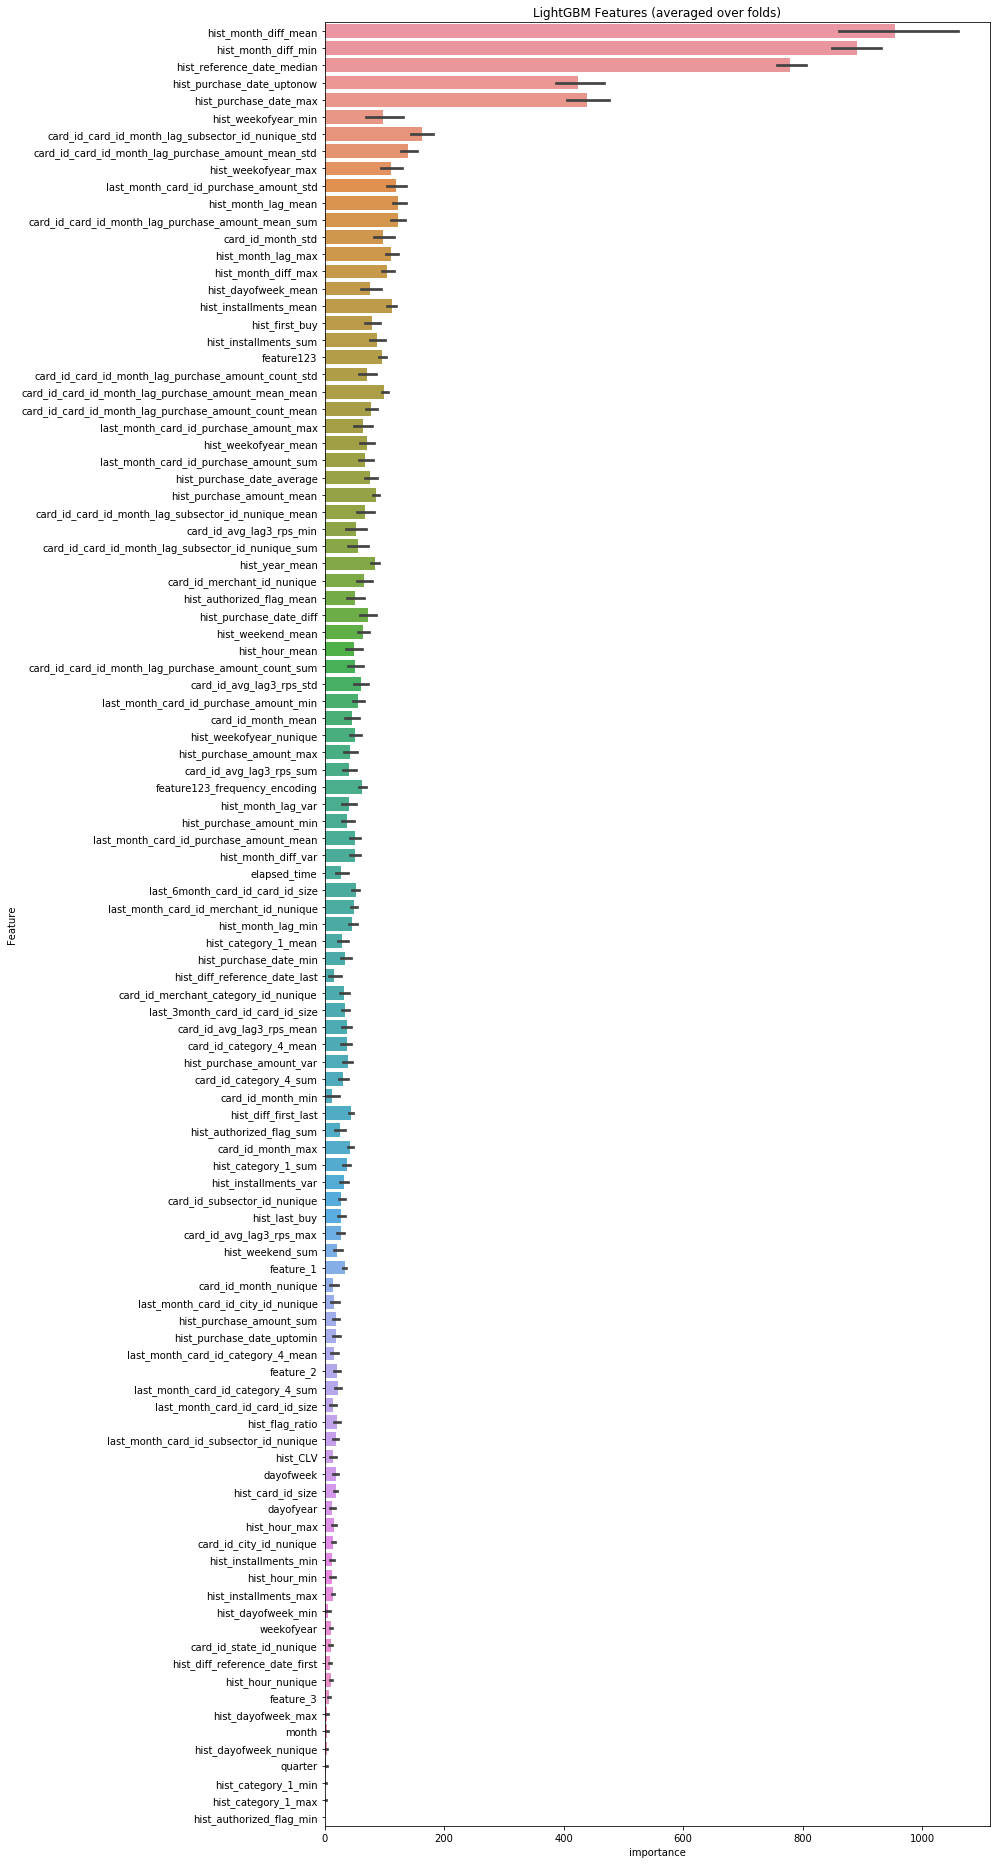

In [49]:
filename = '{}_cv{:.6f}'.format(datetime.now().strftime('%Y%m%d_%H%M%S'), cv_score)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('fi/{}_lgbm_importances.png'.format(filename))

In [50]:
feature_importance_df.groupby('Feature')['importance'].sum().reset_index().sort_values('importance')

,Feature,importance
36,hist_authorized_flag_min,2
41,hist_category_1_min,5
39,hist_category_1_max,11
103,quarter,19
102,month,29
46,hist_dayofweek_nunique,30
43,hist_dayofweek_max,32
45,hist_dayofweek_min,49
33,feature_3,66
48,hist_diff_reference_date_first,84


In [51]:
mean_absolute_error(np.floor(oof), target)

1.826889664787815

In [52]:
result = pd.concat([pd.DataFrame(oof,columns=['oof']),pd.DataFrame(target).reset_index(drop=True)],axis=1)

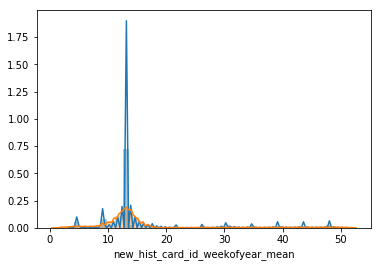

In [53]:
sns.distplot(result['oof'])
sns.distplot(result['new_hist_card_id_weekofyear_mean'])

In [56]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df['new_hist_weekofyear_mean'] = predictions
#sub_df.loc[sub_df['target']<-9,'target'] = -33.21928095
sub_df.to_csv("input/fill_new_hist_weekofyear_mean_{}.csv".format(filename), index=False)